In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib import colormaps
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path as MplPath
import matplotlib.cm

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib

import polars as pl
pl.Config.set_tbl_rows(-1);
pl.Config.set_fmt_str_lengths(50);

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
os.environ["PATH"] += ":" + "/software/treeoflife/shpc/0.1.26/wrapper/quay.io/biocontainers/bedtools/2.31.1--hf5e1c6e_1/bin"
import pybedtools


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Read events

In [4]:
events_df = pl.read_parquet(
    "/lustre/scratch122/tol/projects/sperm/results/recombination_events_sperm_20250325.parquet",
)

# Read centromeres

In [5]:
cyto_T2T_df = pl.read_csv(
    "http://t2t.gi.ucsc.edu/chm13/hub/t2t-chm13-v2.0/download/chm13v2.0_cytobands_allchrs.bed.gz",
    separator='\t',
    new_columns=["chrom", "cyto_start", "cyto_end", "cyto_name", "type"],
    has_header=False,
)

cent_df = cyto_T2T_df.filter(pl.col("type") == "acen")

In [6]:
cent_df.head()

chrom,cyto_start,cyto_end,cyto_name,type
str,i64,i64,str,str
"""chr1""",121796048,124048267,"""p11.1""","""acen"""
"""chr1""",124048267,126300487,"""q11""","""acen"""
"""chr10""",39633793,40649191,"""p11.1""","""acen"""
"""chr10""",40649191,41664589,"""q11.1""","""acen"""
"""chr11""",51035789,52743313,"""p11.11""","""acen"""


# Read masks

In [7]:
trf_columns = ["start_pos_1based", "end_pos_1based", "repeat_length", "n_copies", "concensus_length", "percent_matches", "percent_indels", "alignment_score", "percent_A", "percent_C", "percent_G", "percent_T", "entropy", "concensus", "full_repeat", "flank_seq1", "flank_seq2"]

def open_trf(filename, chrom, start):
    return (
        pl.scan_csv(
            filename,
            has_header = False,
            separator = " ",
            comment_prefix = "@",
            new_columns = trf_columns,
        )
        .select(
            pl.lit(chrom).alias("chrom"),
            (pl.col("start_pos_1based") - 1 + int(start)).alias("start_pos_0based"),
            (pl.col("end_pos_1based") + int(start)).alias("end_pos_0based")
        )
    )

def open_all_trfs(chrom):
    dfs = [
        open_trf(f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/global/t2t/{chrom}.{start}.fasta.trf.dat", chrom, start) \
            for start in range(0, liftover.T2T_chromosome_sizes_in_bp[chrom], 10_000_000)
    ]
    return pl.concat(dfs).collect()

In [8]:
%%time
chrom_to_trf = {chrom:open_all_trfs(chrom) for chrom in aut_chrom_names}

CPU times: user 4.89 s, sys: 4.36 s, total: 9.25 s
Wall time: 26.2 s


In [9]:
chrom_to_trf["chr1"].head()

chrom,start_pos_0based,end_pos_0based
str,i64,i64
"""chr1""",37,2741
"""chr1""",2745,3255
"""chr1""",3228,3342
"""chr1""",3520,3885
"""chr1""",3520,3885


In [10]:
chrom_to_mask_df = {}
resolution = 1_000_000

for chrom in tqdm.tqdm(aut_chrom_names):
    trf_bed = pybedtools.BedTool.from_dataframe(
        chrom_to_trf[chrom]
        .select("chrom", "start_pos_0based", "end_pos_0based")
        .to_pandas()
    )
    
    sdust = pybedtools.BedTool(f"/lustre/scratch122/tol/projects/sperm/results/Rahbari_20250212/global/T2T/{chrom}.fasta.sdust.dat")
    
    windows = pybedtools.BedTool([
        (chrom, x, x+resolution) \
            for x in range(0, annotate.grch38_chromosome_sizes_in_bp[chrom] + resolution, resolution)
    ])
    
    masked = (sdust
        .cat(trf_bed, postmerge=False).sort()
        .merge()
    )
        
    chrom_to_mask_df[chrom] = pl.from_pandas(
        windows.intersect(masked, wao=True)
        .groupby(g=[1,2,3], c=7)
        .to_dataframe()
    )
    


100%|██████████| 22/22 [01:48<00:00,  4.92s/it]


# Draw

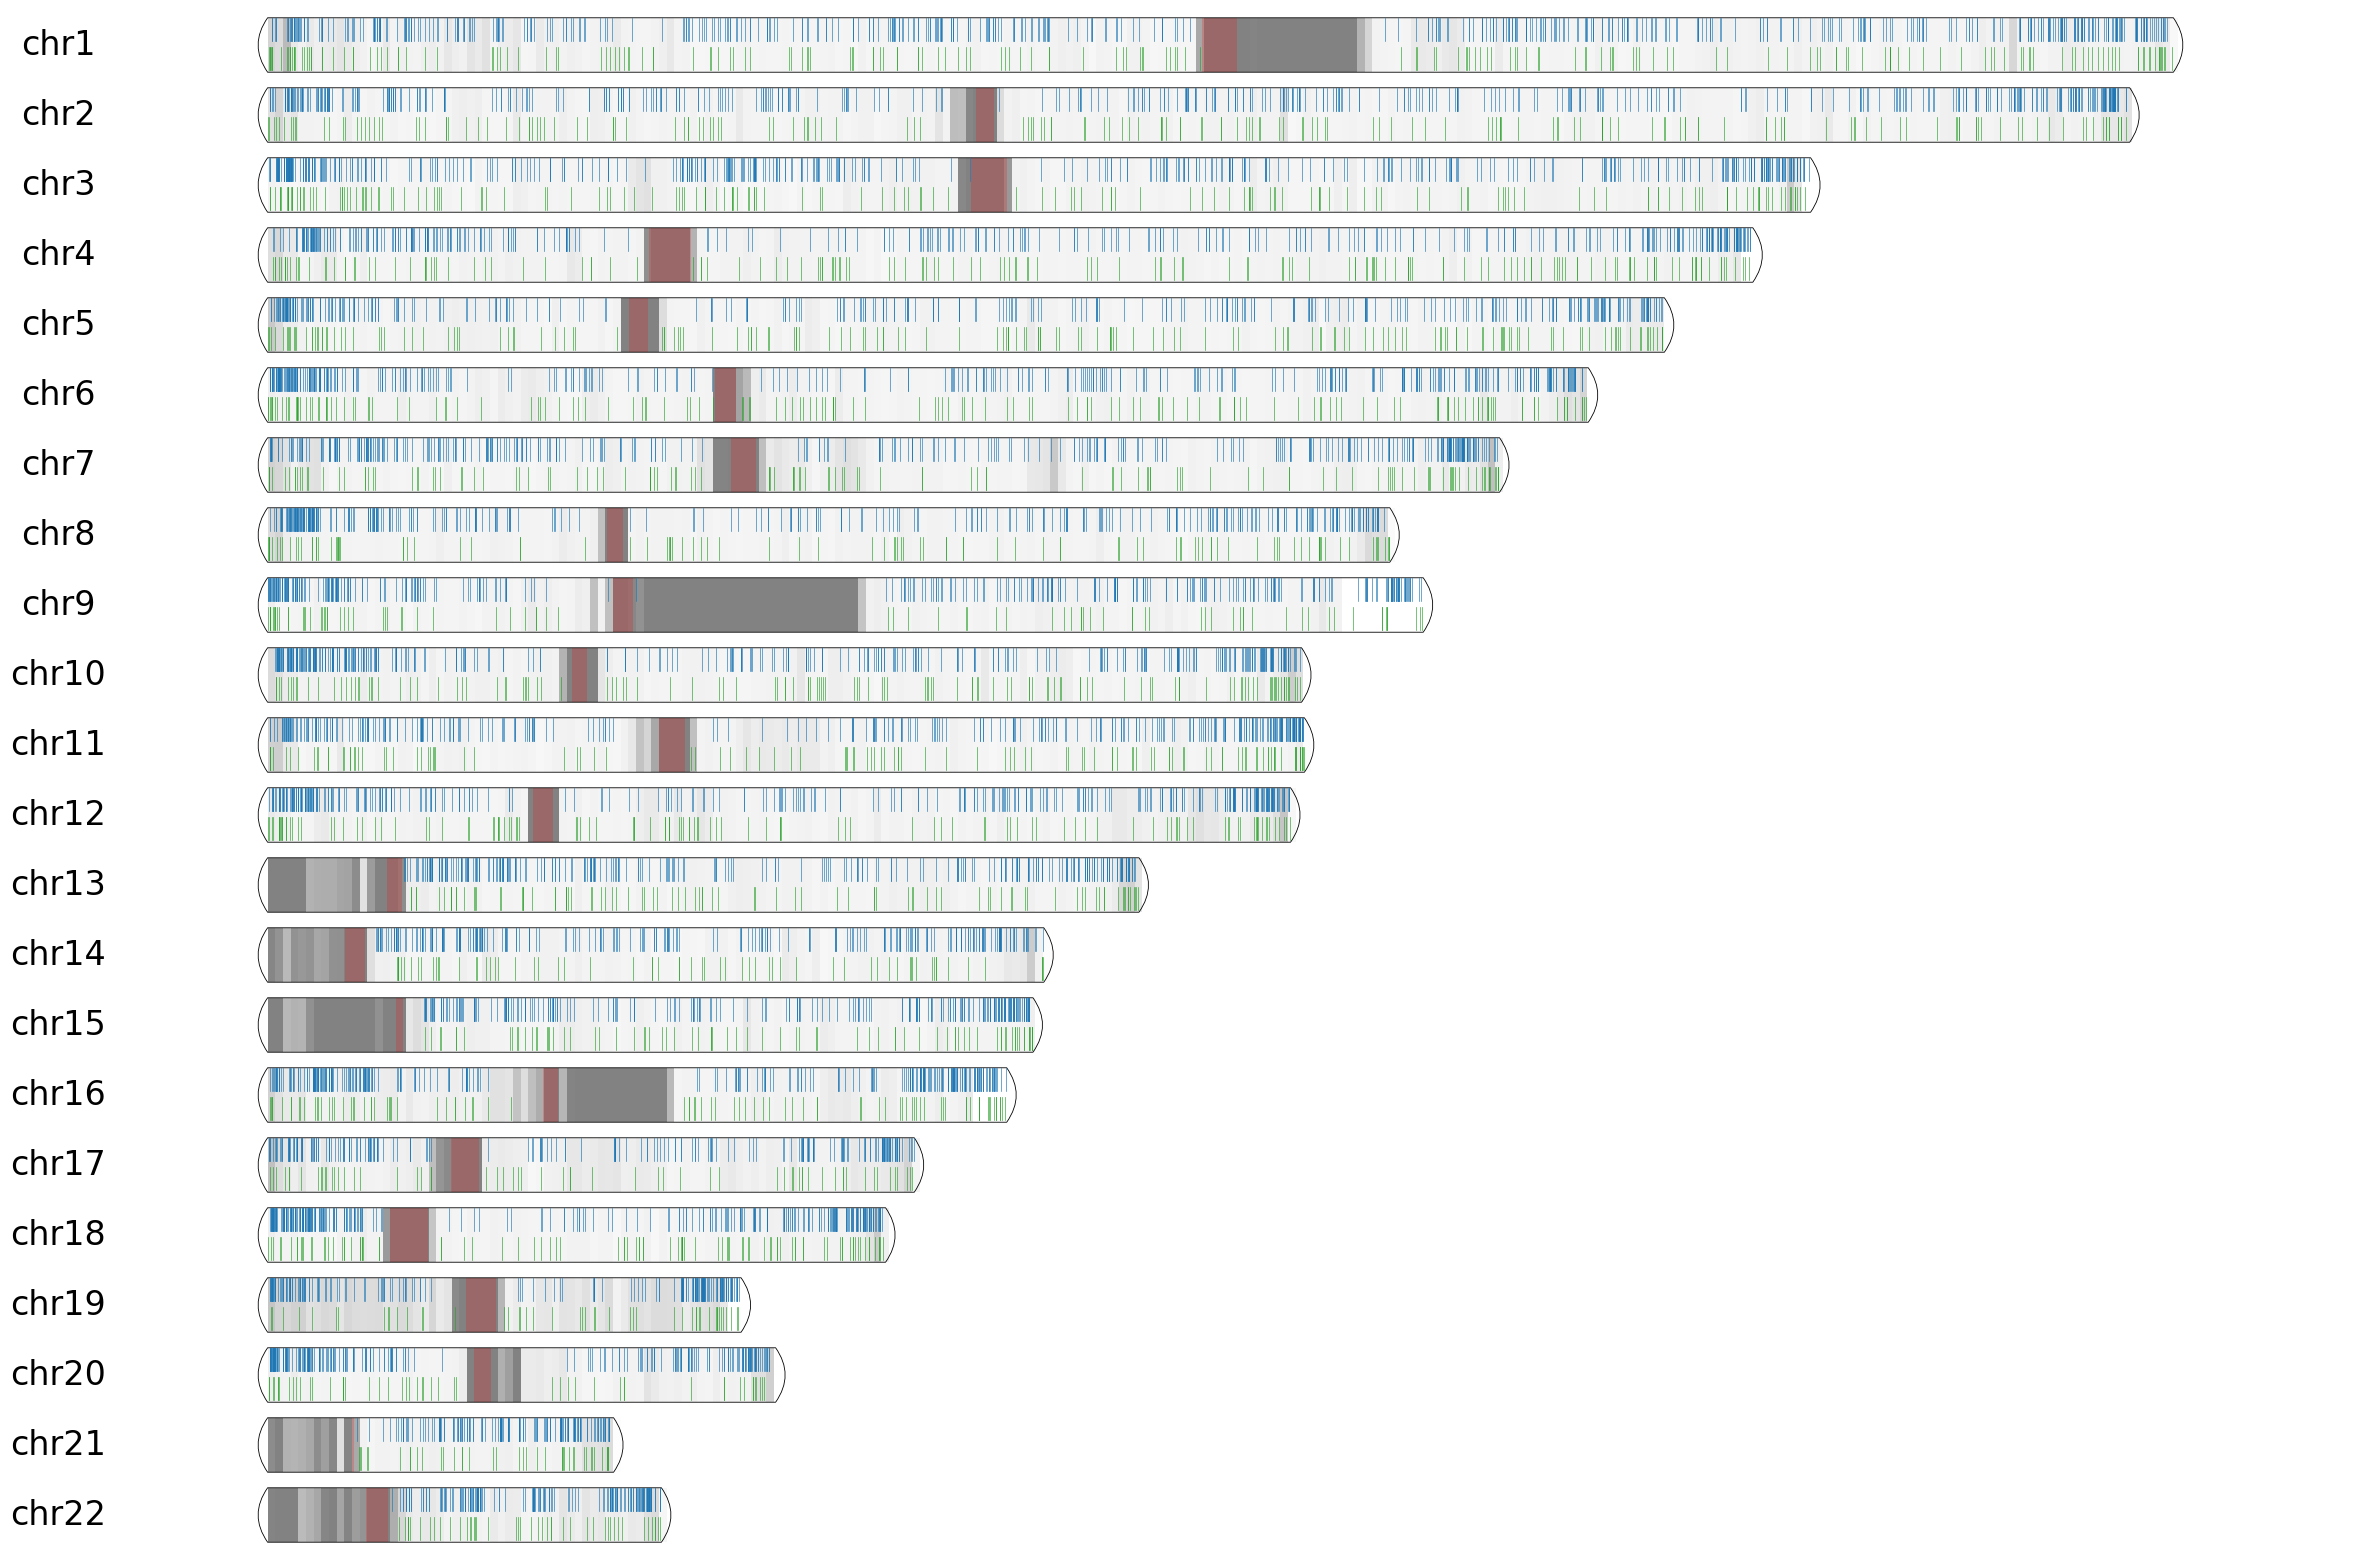

In [15]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=22,
    width_ratios = (1, 60),
    figsize=(30, 20),
    facecolor="white",
)

plt.subplots_adjust(wspace=0, hspace=0) # Adjust horizontal and vertical spacing

from matplotlib import colors
import numpy as np

max_color = 0.7   
cmap = colormaps["Greys"]
new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Greys_half',
    cmap(np.linspace(0, max_color, 256))
)

norm = colors.TwoSlopeNorm(vcenter=0.2, vmin=0, vmax=1)

max_chrom_len = liftover.T2T_chromosome_sizes_in_bp[aut_chrom_names[0]]
for n_chrom, chrom in enumerate(aut_chrom_names):
    # Label
    ax = axes[n_chrom, 0]
    ax.text(
        0.5, 
        0.5, 
        chrom, 
        horizontalalignment='center', 
        verticalalignment='center',
        fontsize=24,
    )
    ax.axis('off')
    
    # Main
    ax = axes[n_chrom, 1]
    chr_len = liftover.T2T_chromosome_sizes_in_bp[chrom] / max_chrom_len
    
    height = 7.0
    height_ylim_pad = 1.0
    lower_anchor = 0.0
    ymid = height / 2
    curve = 0.01
    lw = 0.5
    edge_lw = 0.6
    event_height = 3
    event_alpha = 0.9
    

    # Plot coverage first
    cov_df = chrom_to_mask_df[chrom]
    for _, start, end, n_bp in cov_df.rows():
        color = new_cmap(norm(np.clip(n_bp / resolution, 0, max_color)))
        ax.add_patch(
            patches.Rectangle(
                xy = (start / max_chrom_len, 0), 
                width = (end-start) / max_chrom_len, 
                height = height, 
                linewidth=0, 
                facecolor=color,
            )
        )

    # Then centromemere
    cdf = cent_df.filter(pl.col("chrom") == chrom)
    for _, start, end, _, _ in cdf.rows():        
        ax.add_patch(
            patches.Rectangle(
                xy = (start / max_chrom_len, 0), 
                width = (end-start) / max_chrom_len, 
                height = height, 
                linewidth=0, 
                facecolor="red",
                alpha=0.2,
            )
        )
        
    # Outline path: no centromere, just a continuous shape with rounded telomeres
    outline = [
        (MplPath.MOVETO, (lower_anchor, height)),
        (MplPath.LINETO, (chr_len, height)),
        # Right telomere: )
        (MplPath.CURVE3, (chr_len  + curve, ymid)),
        (MplPath.LINETO, (chr_len, lower_anchor)),
        (MplPath.LINETO, (lower_anchor, lower_anchor)),
        # Left telomere: (
        (MplPath.CURVE3, (lower_anchor -  curve, ymid)),
        (MplPath.LINETO, (lower_anchor, height)),
        (MplPath.CLOSEPOLY, (lower_anchor, height)),
    ]

    codes, verts = zip(*outline)
    path = MplPath(verts, codes)
    patch = PathPatch(path, facecolor="none", edgecolor="black", linewidth=edge_lw)

    # Plotting
    ax.add_patch(patch)
    ax.set_xlim(-0.1, 1+0.1)
    ax.set_ylim(-height_ylim_pad, height+height_ylim_pad)
    # ax.set_aspect('equal')
    ax.axis('off')
    
    # Plot COs:
    poses = events_df.filter((pl.col("event_type") == "CO") & (pl.col("chrom") == chrom))["T2T_reference_start"].sort().to_numpy() 
    relative_poses = poses / max_chrom_len
    for pos in relative_poses:
        ax.plot(
            [pos, pos],
            [height, height - event_height],
            color=CO_color,
            lw=lw,
            label="CO",
            alpha=event_alpha,
        )
        
    # Plot NCOs:
    poses = events_df.filter((pl.col("event_type") == "NCO") & (pl.col("chrom") == chrom))["T2T_reference_start"].sort().to_numpy() 
    relative_poses = poses / max_chrom_len
    for pos in relative_poses:
        ax.plot(
            [pos, pos],
            [0 + edge_lw/2, 0 + edge_lw/2 + event_height],
            color=NCO_color,
            lw=lw,
            label="NCO",
            alpha=event_alpha,
        )
        
fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/revision/fig_all_chroms.pdf")

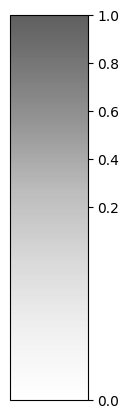

In [16]:
fig, ax = plt.subplots(figsize=(1, 5))
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=new_cmap)
fig.colorbar(sm, cax=ax)
plt.show()

fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/revision/fig_all_chroms_colorbar.pdf")

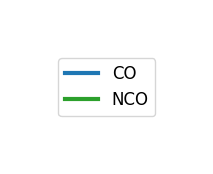

In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the legend entries
legend_elements = [
    Line2D([0], [0], color=CO_color, lw=3, label='CO'),        # Blue
    Line2D([0], [0], color=NCO_color, lw=3, label='NCO'),       # Green
]

# Create a new figure for the legend
fig, ax = plt.subplots(figsize=(2.5, 2))
ax.axis('off')  # Hide axes

# Create the legend
legend = ax.legend(
    handles=legend_elements,
    loc='center',
    frameon=True,
    fontsize='large'
)

plt.show()

fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/revision/fig_all_chroms_l.pdf")

# Draw

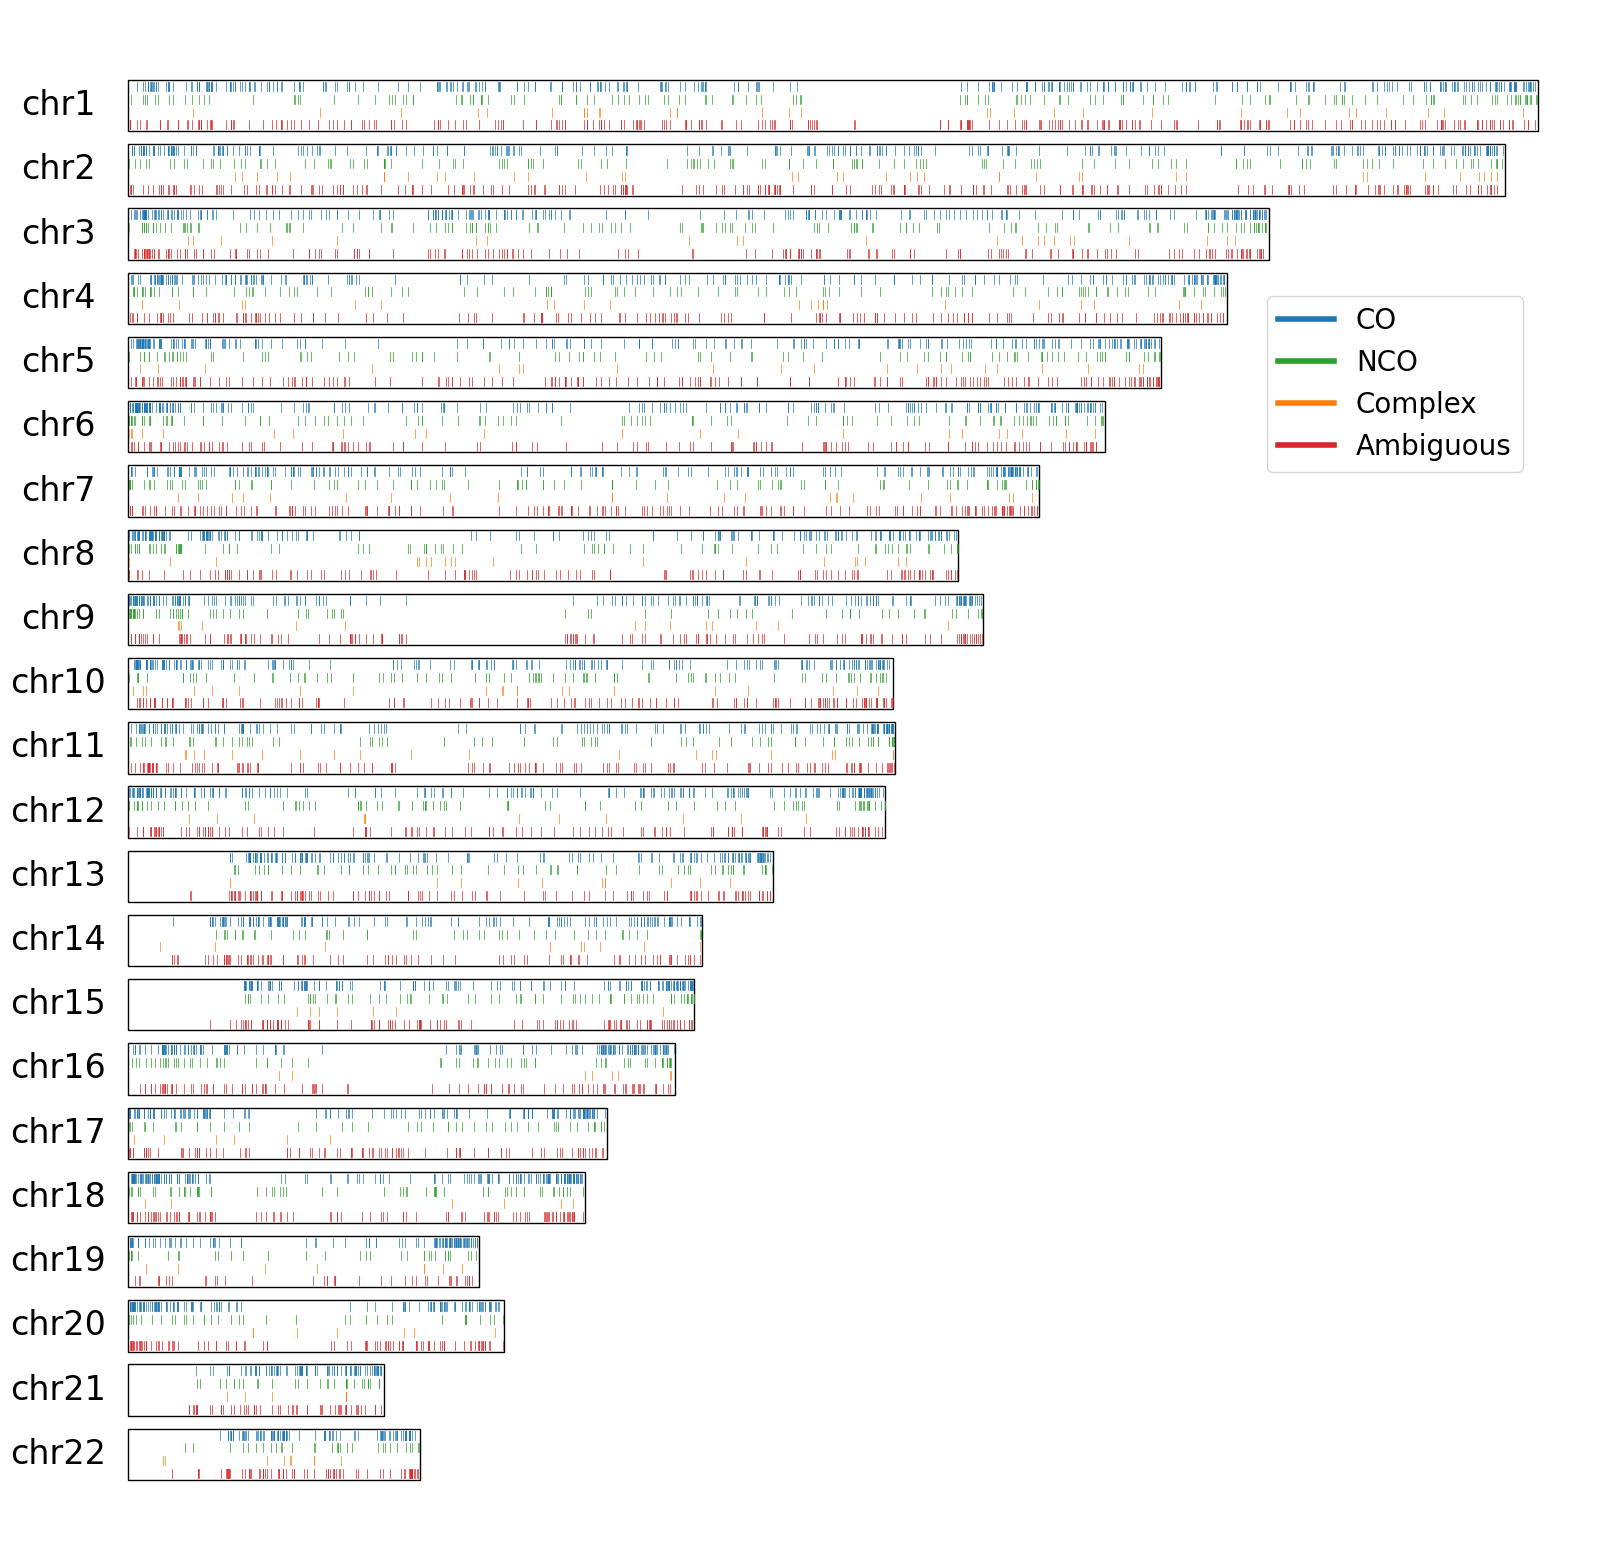

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))

# Draw the chromosome frames
max_chrom_len = liftover.T2T_chromosome_sizes_in_bp[aut_chrom_names[0]]
for n_chrom, chrom in enumerate(aut_chrom_names):
    chrom_len = liftover.T2T_chromosome_sizes_in_bp[chrom] / max_chrom_len
    
    patch = patches.Rectangle(
        (0, n_chrom), 
        chrom_len, 
        0.8, 
        linewidth=1, 
        edgecolor='black', 
        facecolor='none',
    )
    
    ax.add_patch(patch)
    
#     patch = patches.Rectangle(
#         (0 + cent_dict[chrom][0] / max_chrom_len, n_chrom), 
#         (cent_dict[chrom][1] - cent_dict[chrom][0]) / max_chrom_len, 
#         0.8, 
#         linewidth=2, 
#         edgecolor='black', 
#         facecolor='lightgray',
#     )
    
#     ax.add_patch(patch)
    
    ax.text(
        -0.05, 
        n_chrom+0.4, 
        chrom, 
        horizontalalignment='center', 
        verticalalignment='center',
        fontsize=24,
    )#, transform=ax.transAxes)
    
y_pad = 0.2
x_pad = 0.2
#ax.set_ylim(-y_pad, len(aut_chrom_names) + y_pad)
#ax.set_xlim(-x_pad, 1 + x_pad)
ax.invert_yaxis()

ax.spines[:].set_visible(False);
ax.set_xticks([]);
ax.set_yticks([]);

# Add the events
event_slack = 0.03
event_offset = 0.2
lw = 0.5
for n_chrom, chrom in enumerate(aut_chrom_names):
    df = (dense_reads_with_detection_df
        .filter(pl.col("chrom") == chrom)
        .filter(pl.col("T2T_reference_start").is_not_null())
    )
    
    # COs
    for row in df.filter(pl.col("high_quality_classification_class") == "CO").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_co, = ax.plot(
            [pos, pos], 
            [n_chrom+event_slack, n_chrom+event_offset-event_slack], 
            color=CO_color,
            lw=lw,
            label="CO",
        );
        
    # NCOs
    for row in df.filter(pl.col("high_quality_classification_class") == "GC").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_nco, = ax.plot(
            [pos, pos], 
            [n_chrom+event_offset+event_slack, n_chrom+event_offset*2-event_slack], 
            color=NCO_color,
            lw=lw,
            label="NCO",
        );
        
    # Complex
    for row in df.filter(pl.col("high_quality_classification_class") == "CNCO").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_complex, = ax.plot(
            [pos, pos], 
            [n_chrom+2*event_offset+event_slack, n_chrom+event_offset*3-event_slack], 
            color=complex_color,
            lw=lw,
            label="Complex",
        );
        
    # Ambiguous
    for row in df.filter(pl.col("high_quality_classification_class") == "ambiguous").iter_rows(named=True):
        pos = ((row["T2T_reference_start"] + row["T2T_reference_end"])/2) / max_chrom_len
        
        line_amb, = ax.plot(
            [pos, pos], 
            [n_chrom+3*event_offset+event_slack, n_chrom+event_offset*4-event_slack], 
            color=ambiguous_color,
            lw=lw,
            label="Ambiguous",
        );
        
leg = ax.legend(
    handles = [line_co, line_nco, line_complex, line_amb],
    loc = (0.78, 0.70),
    fontsize = 20,
);
for line in leg.get_lines()[-4:]:
    line.set_linewidth(4.0)
        

In [12]:
fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/fig_all_chroms.pdf")